In [1]:
import pandas as pd

df_2022 = pd.read_csv(r"/home/takato/comp/kokudo/data/2022/L01-2022P-2K.csv",encoding="cp932")
df_train = pd.read_csv('../data/train.csv')

/tmp/ipykernel_9617/1882913554.py:4: DtypeWarning: Columns (63) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('../data/train.csv')


In [2]:
df_train['year'] = df_train['target_ym'] // 100

In [3]:
# 世界測地系経度（lon）、世界測地系経度（lat）
cols = {'経度':'lon','緯度':'lat','年次':'year','Ｒ４価格':'2019price'}
df_2022 = df_2022.rename(columns=cols)
# df_train.merge(df_2022,on=['year','lon','lat'])

In [4]:
# 3600で割って度に変換 (35度 * 3600 = 126000 くらいのオーダーであるか確認)
# データ例: 緯度 154999.616 -> 154999 / 3600 = 43.05 (札幌) -> 正しい
df_2022['lon'] = pd.to_numeric(df_2022['lon'], errors='coerce') / 3600.0
df_2022['lat'] = pd.to_numeric(df_2022['lat'], errors='coerce') / 3600.0

# 価格の数値化
df_2022['2019price'] = pd.to_numeric(df_2022['2019price'], errors='coerce')

# 必要なカラムのみ抽出
df_2022 = df_2022[['lat', 'lon', '2019price','year']].dropna()

In [5]:
df_train[['lon','lat']].describe()

,lon,lat
count,363924.000000,363924.000000
mean,137.461207,35.300902
std,2.979387,1.625129
min,127.656334,26.090097
25%,135.519223,34.729234
50%,139.314683,35.416999
75%,139.699853,35.726763
max,144.444086,43.856396


In [6]:
df_2022[['lon','lat']].describe()

,lon,lat
count,25993.000000,25993.000000
mean,137.216869,35.698090
std,3.311769,2.358226
min,124.149335,24.337114
25%,135.427566,34.690929
50%,137.982103,35.389147
75%,139.727208,35.947900
max,145.600589,45.421953


In [1]:
from scipy.spatial import cKDTree
def preprocess_land_price(df_land,cols):
    """
    地価公示データの前処理
    座標系が「秒」単位である可能性が高いため、度に変換する。
    """
    print("Preprocessing land price data...")
    
    # 座標変換: ミリ秒/秒単位を度に変換 (日本測地系のデータの場合、世界測地系への変換が必要だが、
    # ここでは簡易的に3600で割る。ずれが小さいと仮定)
    # カラム名が日本語のため、扱いやすい英語名に変更
    df_land = df_land.rename(columns=cols)
    
    # 3600で割って度に変換 (35度 * 3600 = 126000 くらいのオーダーであるか確認)
    # データ例: 緯度 154999.616 -> 154999 / 3600 = 43.05 (札幌) -> 正しい
    df_land['lon'] = pd.to_numeric(df_land['lon'], errors='coerce') / 3600.0
    df_land['lat'] = pd.to_numeric(df_land['lat'], errors='coerce') / 3600.0
    
    # 価格の数値化
    df_land['price_pub'] = pd.to_numeric(df_land['price_pub'], errors='coerce')
    
    # 道路幅員の数値化（データによっては '4.0' などの文字列になっている）
    if 'pub_road_width' in df_land.columns:
        # 文字列として読み込まれている場合を考慮し、数値に変換
        # "0109" のような形式の場合、10.9mを意味する可能性があるが、
        # ここでは単純に数値化する（大小関係が保たれれば決定木には十分）
        df_land['pub_road_width'] = pd.to_numeric(df_land['pub_road_width'], errors='coerce')
    
    # 必要なカラムのみ抽出
    df_land = df_land[['lat', 'lon', 'price_pub','pub_land_use','pub_road_width','pub_land_shape']].dropna()
    
    return df_land

def merge_land_price_spatial(df_tune, df_land):
    """
    cKDTreeを用いて最寄りの地価公示ポイントを検索し、属性を結合する
    """
    print("Spatial joining land price data...")
    
    # tuneデータの座標
    tune_coords = df_tune[['lat', 'lon']].fillna(0).values
    # 地価公示データの座標
    land_coords = df_land[['lat', 'lon']].values
    
    # KDTreeの構築
    tree = cKDTree(land_coords)
    
    # 最近傍探索 (k=1: 最も近い1点)
    distances, indices = tree.query(tune_coords, k=1)
    
    # 結合するカラム
    cols_to_merge = ['price_pub', 'pub_land_use', 'pub_road_width', 'pub_land_shape']
    cols_to_merge = [c for c in cols_to_merge if c in df_land.columns]
    
    # df_landのインデックスを使って値を取得
    for col in cols_to_merge:
        df_tune[f'nearest_{col}'] = df_land.iloc[indices][col].values
        
    df_tune['dist_to_land_price'] = distances
    
    return df_tune

In [2]:
import pandas as pd
df_2023 = pd.read_csv(r"/home/takato/comp/kokudo/data/2023/L01-2023P-2K.csv",encoding="cp932")
df_2022 = pd.read_csv(r"/home/takato/comp/kokudo/data/2022/L01-2022P-2K.csv",encoding="cp932")
df_2021 = pd.read_csv(r"/home/takato/comp/kokudo/data/2021/L01-2021P-2K.csv",encoding="cp932")
df_2020 = pd.read_csv(r"/home/takato/comp/kokudo/data/2020/L01-2020P-2K.csv",encoding="cp932")
df_2019 = pd.read_csv(r"/home/takato/comp/kokudo/data/2019/L01-31P-2K.csv",encoding="cp932")
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
cols19 = {
        '経度': 'lon',
        '緯度': 'lat',
        'Ｈ３１価格': 'price_pub', # 2019年(H31)の価格
        '用途区分': 'pub_land_use',      # L01_022
        '前面道路の幅員': 'pub_road_width', # L01_024
        '形状区分': 'pub_land_shape'     # L01_025
}
cols20 = {
        '経度': 'lon',
        '緯度': 'lat',
        'Ｒ２価格': 'price_pub', # 2020年(R2)の価格
        '用途区分': 'pub_land_use',      # L01_022
        '前面道路の幅員': 'pub_road_width', # L01_024
        '形状区分': 'pub_land_shape'     # L01_025
}
cols21 = {
        '経度': 'lon',
        '緯度': 'lat',
        'Ｒ３価格': 'price_pub', # 2021年(R3)の価格
        '用途区分': 'pub_land_use',      # L01_022
        '前面道路の幅員': 'pub_road_width', # L01_024
        '形状区分': 'pub_land_shape'     # L01_025
}
cols22 = {
        '経度': 'lon',
        '緯度': 'lat',
        'Ｒ４価格': 'price_pub', # 2022年(R4)の価格
        '用途区分': 'pub_land_use',      # L01_022
        '前面道路の幅員': 'pub_road_width', # L01_024
        '形状区分': 'pub_land_shape'     # L01_025
}
cols23 = {
        '経度': 'lon',
        '緯度': 'lat',
        'Ｒ５価格': 'price_pub', # 2023年(R5)の価格
        '用途区分': 'pub_land_use',      # L01_022
        '前面道路の幅員': 'pub_road_width', # L01_024
        '形状区分': 'pub_land_shape'     # L01_025
}
df_2023 = preprocess_land_price(df_2023,cols23)
df_2022 = preprocess_land_price(df_2022,cols22)
df_2021 = preprocess_land_price(df_2021,cols21)
df_2020 = preprocess_land_price(df_2020,cols20)
df_2019 = preprocess_land_price(df_2019,cols19)

/tmp/ipykernel_8090/2633435364.py:7: DtypeWarning: Columns (63) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('../data/train.csv')


Preprocessing land price data...
Preprocessing land price data...
Preprocessing land price data...
Preprocessing land price data...
Preprocessing land price data...


/tmp/ipykernel_8090/2633435364.py:8: DtypeWarning: Columns (46,55,56,63,146) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('../data/test.csv')


In [3]:
df_train['year'] = df_train['target_ym'] // 100
df_train_2019 = df_train[df_train['year']==2019]
df_train_2020 = df_train[df_train['year']==2020]
df_train_2021 = df_train[df_train['year']==2021]
df_train_2022 = df_train[df_train['year']==2022]

In [10]:
df_train_2021

,target_ym,money_room,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,building_name_ruby,homes_building_name,...,bank_distance,shopping_street_distance,est_other_name,est_other_distance,statuses,parking_keiyaku,money_hoshou_company,free_rent_duration,free_rent_gen_timing,year
186257,202101,14990000,185879,1,2014-06-27 21:09:40,2021-07-31 00:10:05,4,NaN,NaN,桑名市大字東方418-6,...,NaN,NaN,NaN,NaN,210101/220401/220701/210302/220601/230401/3105...,NaN,NaN,NaN,NaN,2021
186258,202101,22000000,185059,1,2014-06-27 21:09:43,2021-12-05 00:10:05,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,253701/250301/220801/230103/220401/230801/2207...,NaN,NaN,NaN,NaN,2021
186259,202101,28000000,163882,1,2014-06-27 19:24:11,2021-02-12 00:10:05,4,NaN,NaN,中古戸建 知多市南粕谷4丁目,...,NaN,NaN,幼稚園・保育園,600.0,250301/210101/290501/290901/210301/210201,NaN,NaN,NaN,NaN,2021
186260,202101,25800000,170711,1,2014-06-27 21:09:46,2024-04-01 19:46:59,4,NaN,NaN,桑名市赤尾台9丁目,...,NaN,2336.0,ワークマン 桑名七和店,3079.0,253501/220301/220401/210101/290401/253401/2207...,NaN,NaN,NaN,NaN,2021
186261,202101,16800000,148010,1,2014-06-27 21:09:47,2024-04-01 19:46:59,4,NaN,NaN,桑名市藤が丘三丁目戸建,...,NaN,NaN,NaN,NaN,290401/290101/230401/290301/240201,NaN,NaN,NaN,NaN,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274353,202107,20000000,42250,1,2014-06-27 19:24:09,2023-05-22 00:10:05,999,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,220301/253401/210101/220601/210301/210201/2401...,NaN,NaN,NaN,NaN,2021
274354,202107,34980000,195067,1,2014-06-27 21:09:21,2021-09-22 00:10:05,4,NaN,NaN,船橋市馬込西3丁目 1号棟,...,NaN,NaN,日の丸幼稚園,370.0,250301/220801/230601/220401/230801/220701/2103...,NaN,NaN,NaN,NaN,2021
274355,202107,22500000,125898,1,2014-06-27 21:09:26,2024-04-01 19:46:59,4,NaN,NaN,桑名市江場,...,780.0,NaN,NaN,NaN,250301/230103/220701/210302/220601/230401/3402...,NaN,NaN,NaN,NaN,2021
274356,202107,17980000,196279,1,2014-06-27 21:09:31,2024-04-01 19:46:59,4,NaN,NaN,五反田 太陽光発電システム付きオール電化住宅,...,590.0,NaN,NaN,NaN,250301/230103/220401/230801/220701/210302/2206...,NaN,NaN,NaN,NaN,2021


In [4]:
df_test = merge_land_price_spatial(df_test, df_2023)
df_train_2022 = merge_land_price_spatial(df_train_2022, df_2022)
df_train_2021 = merge_land_price_spatial(df_train_2021, df_2021)
df_train_2020 = merge_land_price_spatial(df_train_2020, df_2020)
df_train_2019 = merge_land_price_spatial(df_train_2019, df_2019)

Spatial joining land price data...
Spatial joining land price data...
Spatial joining land price data...
Spatial joining land price data...
Spatial joining land price data...


/tmp/ipykernel_8090/332500152.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tune[f'nearest_{col}'] = df_land.iloc[indices][col].values
/tmp/ipykernel_8090/332500152.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tune[f'nearest_{col}'] = df_land.iloc[indices][col].values
/tmp/ipykernel_8090/332500152.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [5]:
df_test.to_csv('../data/2023/test.csv')
df_train_2022.to_csv('../data/2022/train_2022.csv')
df_train_2021.to_csv('../data/2021/train_2021.csv')
df_train_2020.to_csv('../data/2020/train_2020.csv')
df_train_2019.to_csv('../data/2019/train_2019.csv')

In [6]:
df_test = pd.read_csv('../data/2023/test.csv')

/tmp/ipykernel_8090/2152924333.py:1: DtypeWarning: Columns (47,56,57,64,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('../data/2023/test.csv')


In [7]:
train_df = pd.DataFrame()
train_df = pd.concat([df_train_2022,df_train_2021,df_train_2020,df_train_2019],axis=0)

In [8]:
import numpy as np
train_df['log_money_room'] = np.log1p(train_df['money_room'])

In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import warnings
from collections import Counter

In [ ]:
class FeatureProcessor:
    """train/testで一貫した前処理を行うクラス"""
    
    def __init__(self):
        self.top_tags = {}  # タグカラムごとの頻出タグリスト
        self.label_encoders = {}  # カテゴリカラムごとのLabelEncoder
        self.median_built = None
        self.cat_cols = [
            'building_type', 'building_structure', 'floor_plan_code', 
            'prefecture', 'city', 'nearest_pub_land_use'
        ]
        self.use_cols = None
    
    def fit(self, df):
        """trainデータから変換ルールを学習"""
        df = df.copy()
        
        # 築年の中央値を記録
        self.median_built = df['year_built'].median()
        
        # タグの頻出リストを作成
        for col in ['building_tag_id', 'unit_tag_id']:
            df[col] = df[col].astype(str).fillna('')
            all_tags = []
            for tags in df[col]:
                if tags == '' or tags == 'nan':
                    continue
                all_tags.extend(tags.split('/'))
            self.top_tags[col] = [tag for tag, _ in Counter(all_tags).most_common(20)]
        
        # LabelEncoderをfit
        df = self._extract_address(df)
        for col in self.cat_cols:
            if col in df.columns:
                self.label_encoders[col] = LabelEncoder()
                df[col] = df[col].astype(str).fillna('unknown')
                self.label_encoders[col].fit(df[col])
        
        return self
    
    def transform(self, df, is_train=True):
        """データを変換"""
        df = df.copy()
        
        # --- A. 日付・築年数処理 ---
        df['target_year'] = df['target_ym'] // 100
        df['target_month'] = df['target_ym'] % 100
        
        df['year_built'] = df['year_built'].fillna(self.median_built)
        df['built_year'] = df['year_built'] // 100
        df['built_month'] = df['year_built'] % 100
        
        df['building_age_months'] = (
            (df['target_year'] - df['built_year']) * 12 + 
            (df['target_month'] - df['built_month'])
        )
        df['building_age_months'] = df['building_age_months'].clip(lower=0)
        
        # --- B. タグ情報の展開 ---
        for col in ['building_tag_id', 'unit_tag_id']:
            df[col] = df[col].astype(str).fillna('')
            for tag in self.top_tags[col]:
                df[f'has_tag_{tag}'] = df[col].apply(
                    lambda x: 1 if tag in x.split('/') else 0
                )
        
        # --- C. 住所からの抽出 ---
        df = self._extract_address(df)
        
        # --- D. カテゴリカル変数のエンコード ---
        for col in self.cat_cols:
            if col in df.columns and col in self.label_encoders:
                df[col] = df[col].astype(str).fillna('unknown')
                le = self.label_encoders[col]
                known_classes = set(le.classes_)
                # 既知ならエンコード、未知なら-1
                df[col] = df[col].apply(
                    lambda x: le.transform([x])[0] if x in known_classes else -1
                )
        
        # --- E. 使用するカラムを選定 ---
        use_cols = [
            'building_age_months', 'unit_area', 'total_floor_area', 
            'lon', 'lat',
            'unit_count', 'floor_count', 'room_floor',
            'building_type', 'building_structure', 'floor_plan_code',
            'prefecture', 'city','dist_to_land_price','nearest_pub_land_use','nearest_pub_road_width','nearest_price_pub'
        ]
        # タグフラグも追加
        use_cols += [c for c in df.columns if 'has_tag_' in c]
        
        # 存在するカラムのみ使用
        use_cols = [c for c in use_cols if c in df.columns]
        self.use_cols = use_cols
        
        return df[use_cols]
    
    def fit_transform(self, df):
        """fitとtransformを同時に実行"""
        self.fit(df)
        return self.transform(df, is_train=True)
    
    def _extract_address(self, df):
        """住所から都道府県・市区町村を抽出"""
        df['prefecture'] = df['full_address'].str.extract(r'([^都道府県]+[都道府県])')
        df['city'] = df['full_address'].str.extract(r'[都道府県]([^市区町村]+[市区町村])')
        return df

In [11]:
# 前処理実行
processor = FeatureProcessor()
X_train = processor.fit_transform(train_df)



In [12]:
X_test = processor.transform(df_test, is_train=False)

In [20]:
processor.label_encoders

{'building_type': LabelEncoder(),
 'building_structure': LabelEncoder(),
 'floor_plan_code': LabelEncoder(),
 'prefecture': LabelEncoder(),
 'city': LabelEncoder(),
 'nearest_pub_land_use': LabelEncoder()}

In [21]:
X_test['nearest_pub_land_use']

0          2
1          1
2          1
3          0
4          1
          ..
112432     1
112433    11
112434     9
112435     1
112436     7
Name: nearest_pub_land_use, Length: 112437, dtype: int64

In [13]:
# ---------------------------------------------------------
# 3. モデリング（LightGBM）
# ---------------------------------------------------------
y = train_df['log_money_room']
print("\nTraining Model...")

folds = KFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X_train))
test_preds = np.zeros(len(X_test))
models = []

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'random_state': 42
}

for fold, (train_idx, val_idx) in enumerate(folds.split(X_train, y)):
    X_tr, y_tr = X_train.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=0)
        ]
    )
    
    oof_preds[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    
    # テストデータの予測（各foldの平均を取る）
    test_preds += model.predict(X_test, num_iteration=model.best_iteration) / folds.n_splits
    
    models.append(model)
    print(f"Fold {fold+1} RMSE: {model.best_score['valid_1']['rmse']:.4f}")

# ---------------------------------------------------------
# 4. 結果評価と特徴量重要度
# ---------------------------------------------------------
mae = mean_absolute_error(np.expm1(y), np.expm1(oof_preds))
print(f"\nOverall MAE: {mae:,.0f} JPY")

# 特徴量重要度の表示
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.mean([m.feature_importance(importance_type='gain') for m in models], axis=0)
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(importance_df.head(10).to_string(index=False))

# ---------------------------------------------------------
# 5. 予測結果の出力
# ---------------------------------------------------------
# 対数を戻して実際の価格に変換
df_test['predicted_money_room'] = np.expm1(test_preds)

# 提出用ファイルの作成（必要なカラムに応じて調整）
submission = pd.DataFrame({
    'id': df_test.index if 'id' not in df_test.columns else df_test['id'],
    'money_room': df_test['predicted_money_room']
})
submission.to_csv('../data/submission.csv', index=False)

print(f"\nPrediction saved to submission.csv")
print(f"Prediction stats:")
print(f"  Min: {submission['money_room'].min():,.0f} JPY")
print(f"  Max: {submission['money_room'].max():,.0f} JPY")
print(f"  Mean: {submission['money_room'].mean():,.0f} JPY")


Training Model...
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.173593	valid_1's rmse: 0.233947
Fold 1 RMSE: 0.2339
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.173481	valid_1's rmse: 0.236006
Fold 2 RMSE: 0.2360
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.173258	valid_1's rmse: 0.237025
Fold 3 RMSE: 0.2370
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.173614	valid_1's rmse: 0.234783
Fold 4 RMSE: 0.2348
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.173963	valid_1's rmse: 0.234034
Fold 5 RMSE: 0.2340

Overall MAE: 4,171,747 JPY

Top 10 

In [14]:
import pandas as pd
importance = pd.DataFrame()
importance['feature'] = X_train.columns
importance['gain'] = models[0].feature_importance(importance_type='gain')
print("\nTop 10 Important Features:")
print(importance.sort_values(by='gain', ascending=False).head(10))


Top 10 Important Features:
                feature           gain
0   building_age_months  199970.138050
3                   lon  147134.149476
1             unit_area  139228.229394
4                   lat   96096.939980
11           prefecture   50340.341109
13   dist_to_land_price   38545.358461
12                 city   24183.053251
6           floor_count   23581.774861
36       has_tag_230401   16930.477017
10      floor_plan_code   15372.328325


ImportError: You must install graphviz and restart your session to plot tree.

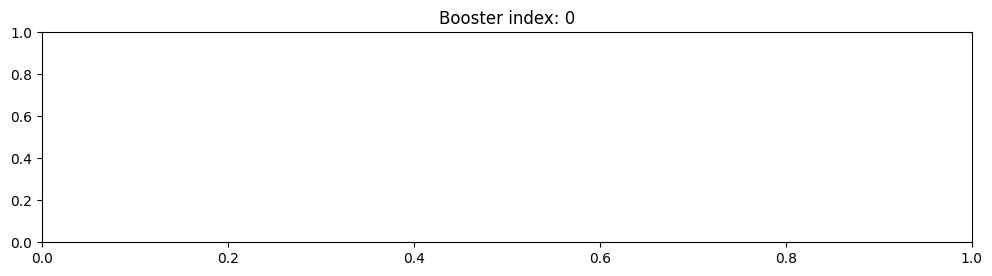

In [25]:
import matplotlib.pyplot as plt
rows = 2
cols = 1
fig = plt.figure(figsize=(12, 6))
for i in range(rows * cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(f'Booster index: {i}')
    lgb.plot_tree(booster=models[0],
                    tree_index=i,
                    show_info='internal_value',
                    ax=ax,
                    )
plt.show()